In [1]:
import numpy as np
from types import SimpleNamespace
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import numpy as np


#These are the necassary variables to run the gibbs Sampler
PARAMETERS = {

    #General Knowns
    'nInduX': 11,
    'nInduY': 11,
    'nFineX': 50,
    'nFineY': 50,

    #Knowns to be evaluated
    'dataCoordinates': None,
    'sampleCoordinates': None,
    'induCoordinates': None,
    'fineCoordinates': None,
    'cInduIndu': None,
    'cInduData': None,
    'cInduFine': None,
    'cInduInduChol': None,
    'cInduInduInv': None,

    # Variables
    'P': float,
    'dIndu': None,

    # Priors
    'covLambda': 1,
    'covL': 10,
    'fInduMean': 0,


    # Sampler parameters
    'epsilon': 1e-3,
}

#These are the neccasary variables for synthetic data generation
SYNTHETICPARAMETERS = {

    #Knowns to generate Ground Truth
    'xInitial': 0,
    'yInitial': 0,
    #'min':-30,
    #'max':30,
    'd0': 20,
    'dVariance': 0,
    'nTrajectories': 100,
    'lengthTrajectories': 10,
    'deltaT': 1,

    #Ground Truth
    'dObserved': None,
    
}

#This is the object of data
DATA = {
    'trajectories': None,
    'trajectoriesIndex': None,
    'deltaT': None,
    'nData': None,
    'nTrajectories': None,
}

In [3]:
# This function generates synthetic data
def dataGenerator(generationParam, data):
    
    #initialize
    data = SimpleNamespace(**data)
    generationParam = SimpleNamespace(**generationParam)

    #Extract necassary variables
    xInitial = generationParam.xInitial
    yInitial = generationParam.yInitial
    deltaT = generationParam.deltaT
    d0 = generationParam.d0
    dVariance = generationParam.dVariance
    nTraj = generationParam.nTrajectories
    lengthTraj = generationParam.lengthTrajectories
    nData = nTraj*lengthTraj
    #minimum = generationParam.min
    #maximum = generationParam.max
    
    #Define function that establishes form of diffusion coefficient through space
    def diffusion(point):
        
        xterm = np.exp(-((point[0] - 0)**2)/(2*10**2))
        yterm = np.exp(-((point[1] - 0)**2)/(2*10**2))
        value = 1 + 50*xterm*yterm
        return value

    #Initialize Trajectory
    trajectories = np.empty((0,2))
    tempTraj = np.zeros((lengthTraj,2))
    trajIndex = np.zeros(nData)
    dObserved = np.zeros(nData)
    dObserved[0] = d0

    

    #Sample Trajectory
    for h in range(nTraj):
        
        #initial position
        tempTraj[0] = [xInitial,yInitial]
        trajIndex[h*lengthTraj] = h+1
        

        #loop through full length of each trajectory
        for i in range(1,lengthTraj):

            #Sample diffusion
            mean = tempTraj[i-1]
            dPoint = diffusion(mean)
            sd = np.sqrt(2*dPoint*(deltaT))
            
            tempTraj[i] = np.random.normal(mean, sd)

            #while (np.any(tempTraj[i] < minimum) or np.any(tempTraj[i] > maximum)):
            #    tempTraj[i] = np.random.normal(mean, sd)

            #save index of trajectory and the observed diffusion at that point
            trajIndex[h*lengthTraj+i] = h+1
            dObserved[h*lengthTraj+i] = dPoint

        trajectories = np.concatenate((trajectories,tempTraj))


    #save all variables created
    generationParam.dObserved = dObserved
    data.trajectories = trajectories
    data.nData = nData
    data.deltaT = deltaT
    data.trajectoriesIndex = trajIndex
    data.nTrajectories = generationParam.nTrajectories
    
    
    return generationParam, data

'''This is a function that returns a covariance matrix between two position vectors
    based on square exponential kernal with parameters covLambda and covL'''    
def covMat(coordinates1, coordinates2, covLambda, covL):
    #Create empty matrix for covariance
    C = np.zeros((len(coordinates1), len(coordinates2)))
    
    #loop over all indecies in covariance matrix
    for i in range(len(coordinates1)):
        for j in range(len(coordinates2)):
            #Calculate distance between points
            dist = np.sqrt((coordinates1[i,0] - coordinates2[j,0])**2 + (coordinates1[i,1] - coordinates2[j,1])**2)
            #Determine each element of covariance matrix
            C[i][j] = (covLambda**2)*(np.exp(((-1)*((dist)**2))/(covL**2)))

    #Return Covariance Matrix
    return C

#initialize sampler parameters
def initialization(variables, data):

    #declare variables as object of 
    variables = SimpleNamespace(**variables)

    trajectories = data.trajectories
    nData = data.nData
    nTraj = data.nTrajectories
    trajectoriesIndex = data.trajectoriesIndex
    nInduX = variables.nInduX
    nInduY = variables.nInduY
    nFineX = variables.nFineX
    nFineY = variables.nFineY
    covLambda = variables.covLambda
    covL = variables.covL
    epsilon = variables.epsilon
    
    dataX = trajectories[:,0]
    dataY = trajectories[:,1]
    minX = min(dataX)
    #minX = -20
    minY = min(dataY)
    #minY = -20
    maxX = max(dataX)
    #maxX = 20
    maxY = max(dataY)
    #maxY = 20

   #define coordinates for Inducing points
    x = np.linspace(minX, maxX, nInduX)
    y = np.linspace(minY, maxY, nInduY)
    xTemp, yTemp = np.meshgrid(x, y)
    X = np.reshape(xTemp, -1)
    Y = np.reshape(yTemp, -1)
    induCoordinates = np.vstack((X, Y)).T
    
    #define coordinates for Fine points
    x = np.linspace(minX, maxX, nFineX)
    y = np.linspace(minY, maxY, nFineY)
    xTemp, yTemp = np.meshgrid(x, y)
    X = np.reshape(xTemp, -1)
    Y = np.reshape(yTemp, -1)
    fineCoordinates = np.vstack((X, Y)).T

    #Points of trajectory where learning is possible
    dataCoordinates = np.empty((0,2))
    for i in range((nData-1)):
        if (trajectoriesIndex[i] == trajectoriesIndex[i+1]):
            dataCoordinates = np.vstack((dataCoordinates,trajectories[i]))

    #Points of trajectory that are "sampled"
    sampleCoordinates = np.empty((0,2))
    for i in range(1,nData):
        if (trajectoriesIndex[i] == trajectoriesIndex[i-1]):
            sampleCoordinates = np.vstack((sampleCoordinates,trajectories[i]))

    #detrmine Covarince matrices
    cInduIndu = covMat(induCoordinates, induCoordinates, covLambda, covL)
    cInduData = covMat(induCoordinates, dataCoordinates, covLambda, covL)
    cInduFine = covMat(induCoordinates, fineCoordinates, covLambda, covL)
    cInduInduInv = np.linalg.inv(cInduIndu + epsilon*np.eye(nInduX*nInduY))
    cInduInduChol = np.linalg.cholesky(cInduIndu + np.eye(nInduX*nInduY)*epsilon)
    
    #Initial Guess
    dIndu = 2 * np.ones(nInduX * nInduY)


    #Initial Probability
    dData = cInduData.T @ cInduInduInv @ dIndu
    sd = np.vstack((dData, dData)).T
    prob = np.sum(stats.norm.logpdf(sampleCoordinates, loc = dataCoordinates, scale = np.sqrt(2*sd*1)))

    #save all variable parameters
    variables.sampleCoordinates = sampleCoordinates
    variables.dataCoordinates = dataCoordinates
    variables.induCoordinates = induCoordinates
    variables.fineCoordinates = fineCoordinates
    variables.cInduIndu = cInduIndu
    variables.cInduData = cInduData
    variables.cInduFine = cInduFine
    variables.cInduInduChol = cInduInduChol
    variables.cInduInduInv = cInduInduInv
    variables.dIndu = dIndu
    variables.P = prob

    return variables

def diffusionSampler(variables, data):

    #necassary variables
    nIndu = variables.nInduX*variables.nInduY
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    means = variables.dataCoordinates
    samples = variables.sampleCoordinates
    data = data.trajectories
    chol = variables.cInduInduChol

    # Propose new dIndu
    dInduOld = variables.dIndu
    dInduNew = dInduOld + np.random.randn(nIndu) @ chol * .1

    #Make sure sampled diffusion vallues are all positive
    while np.any(dInduNew<0):
        dInduNew = dInduOld + np.random.randn(nIndu) @ chol * 0.1

    priorMean = np.zeros(nIndu)
    # Calculate probabilities of induced samples
    def probability(dIndu):

        # Prior
        diff = dIndu - priorMean
        prior = np.exp((-0.5) * diff.T @ cInduInduInv @ diff)
        
        #grnd of data associated with fIndu
        dData = cInduData.T @ cInduInduInv @ dIndu
        sd = np.vstack((dData, dData)).T
        
        #Likelihood of that data
        lhood = np.sum(stats.norm.logpdf(samples, loc = means, scale = np.sqrt(2*sd*1)))
        prob = lhood + prior

        return lhood, prob

    #Probability of old and new function
    lhoodOld, pOld = probability(dInduOld)
    lhoodNew, pNew = probability(dInduNew)
    
    #Acceptance value
    acc_prob = pNew - pOld

    if np.log(np.random.rand()) < acc_prob:
        variables.dIndu = dInduNew
        variables.P = lhoodNew

    return variables



In [4]:
# Initialize variables
generationParam, data = dataGenerator(SYNTHETICPARAMETERS, DATA)

variables = initialization(PARAMETERS, data)


In [5]:
dVect = []
dVect.append(variables.dIndu)

pVect = []

In [6]:
for i in range(10000):
    variables = diffusionSampler(variables, data)
    dVect.append(variables.dIndu)
    pVect.append(variables.P)

<ipython-input-3-3c04b1d9c440>:214: RuntimeWarning: invalid value encountered in sqrt
  lhood = np.sum(stats.norm.logpdf(samples, loc = means, scale = np.sqrt(2*sd*1)))


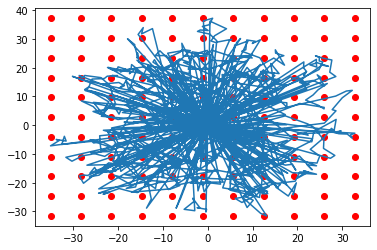

In [7]:
plt.plot(data.trajectories[:,0], data.trajectories[:,1])
plt.scatter(variables.induCoordinates[:,0], variables.induCoordinates[:,1], c = 'r')

4892

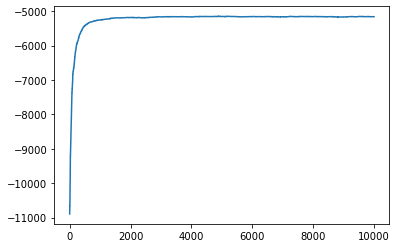

In [8]:
plt.plot(pVect)
pVect.index(max(pVect))

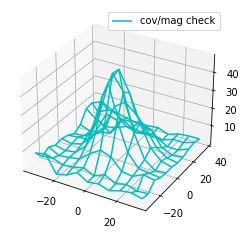

In [9]:
shape = (11,11)
dData = dVect[pVect.index(max(pVect))]
x = np.reshape(variables.induCoordinates[:,0], shape)
y = np.reshape(variables.induCoordinates[:,1], shape)
test = np.reshape(dData, shape)

fig = plt.figure()
bx = fig.add_subplot(projection='3d')
bx.plot_wireframe(x, y, test, rstride = 1, cstride = 1, color = 'c', label = 'cov/mag check')
plt.legend()